open packages

In [1]:
library(spdep)
library(sp)
library(rgdal)
library(INLA)
library(maptools)
library(rgeos)
library(reshape2)

Loading required package: sp
Loading required package: Matrix
rgdal: version: 1.1-10, (SVN revision 622)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.0.1, released 2015/09/15
 Path to GDAL shared files: F:/Users/Jason/Documents/R/win-library/3.3/rgdal/gdal
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: F:/Users/Jason/Documents/R/win-library/3.3/rgdal/proj
 Linking to sp version: 1.2-3 
Loading required package: splines
This is INLA 0.0-1468872408, dated 2016-07-18 (14:43:05+0100).
See www.r-inla.org/contact-us for how to get help.
Checking rgeos availability: TRUE
rgeos version: 0.3-20, (SVN revision 535)
 GEOS runtime version: 3.5.0-CAPI-1.9.0 r4084 
 Linking to sp version: 1.2-3 
 Polygon checking: TRUE 



# spatial models

prep data

In [2]:
df.hosp = read.csv("F:/Users/Jason/Desktop/Health_data/INLA_models/Data/admits_daily_ZCTA.csv",header=T)
df.temps = read.csv("F:/Users/Jason/Desktop/Health_data/INLA_models/Data/zip_temperatures_daily.csv",header=T)
df.daily = merge(df.hosp,df.temps,by=c("DATE","ZIP"),all.x=T)

zips = readShapePoly("F:/Users/Jason/Desktop/Health_data/INLA_models/Data/Shapefiles/dane_zip_data.shp")
temp = poly2nb(zips)
nb2INLA("LDN.graph",temp)
adj1 = paste(getwd(),"/LDN.graph",sep="")
H = inla.read.graph(filename="LDN.graph")

data1 = zips@data; data1$ID = as.numeric(data1$ID); data1$MEDIAN_INC = as.numeric(as.character(data1$MEDIAN_INC))
data.final = merge(df.daily,data1,by="ZIP",all.x=T)
Nareas <- length(data1[,1])

In [9]:
summary(data1)

       ID             ZIP          INTPTLON10      MTFCC10   CLASSFP10
 Min.   : 1.00   Min.   :53508   Min.   :-89.83   G6350:32   B5:32    
 1st Qu.: 8.75   1st Qu.:53532   1st Qu.:-89.53                       
 Median :16.50   Median :53590   Median :-89.40                       
 Mean   :16.50   Mean   :53613   Mean   :-89.41                       
 3rd Qu.:24.25   3rd Qu.:53712   3rd Qu.:-89.30                       
 Max.   :32.00   Max.   :53726   Max.   :-89.03                       
                                                                      
    AWATER10          INTPTLAT10       ALAND10             GEOID10       
 Min.   :       0   Min.   :42.87   Min.   :  1287131   Min.   :5553508  
 1st Qu.:   74330   1st Qu.:43.03   1st Qu.: 23863912   1st Qu.:5553532  
 Median :  542786   Median :43.07   Median : 93889890   Median :5553590  
 Mean   : 1497612   Mean   :43.08   Mean   : 92039458   Mean   :5553613  
 3rd Qu.: 1472956   3rd Qu.:43.12   3rd Qu.:140492377   3rd Qu

fit INLA models

In [12]:
data1$rate = round(data1$ADMISSIONS/data1$POP * 100000)
formula1 = rate ~ 1 + PDISABLED + PNONWHITE + TMIN + f(ID, model="bym", graph=adj1)
mod1 = inla(formula1,family="poisson",data=data1,control.comput=list(dic=TRUE))
round(mod1$summary.fixed,3)
head(round(mod1$summary.random$ID,3))

,mean,sd,0.025quant,0.5quant,0.975quant,mode,kld
(Intercept),9.769,0.921,7.950,9.768,11.588,9.767,0
PDISABLED,7.516,2.110,3.339,7.518,11.675,7.522,0
PNONWHITE,1.652,0.631,0.403,1.652,2.897,1.652,0
TMIN,-0.116,0.067,-0.248,-0.116,0.015,-0.116,0


ID,mean,sd,0.025quant,0.5quant,0.975quant,mode,kld
1,0.010,0.065,-0.118,0.010,0.138,0.010,0
2,-0.062,0.064,-0.190,-0.062,0.065,-0.062,0
3,0.163,0.097,-0.027,0.163,0.354,0.163,0
4,0.119,0.050,0.020,0.119,0.217,0.119,0
5,0.454,0.088,0.280,0.454,0.626,0.454,0
6,-0.123,0.053,-0.228,-0.123,-0.017,-0.123,0


In [13]:
inla.emarginal(exp,mod1$marginals.fixed[[1]])		#dane county mean rates (9.65%)
inla.qmarginal(c(0.025,0.975),inla.tmarginal(exp,mod1$marginals.fixed[[1]]))	#CI for dane county rates

[1] 26900.98

[1]   2694.881 105852.156

map relative risks

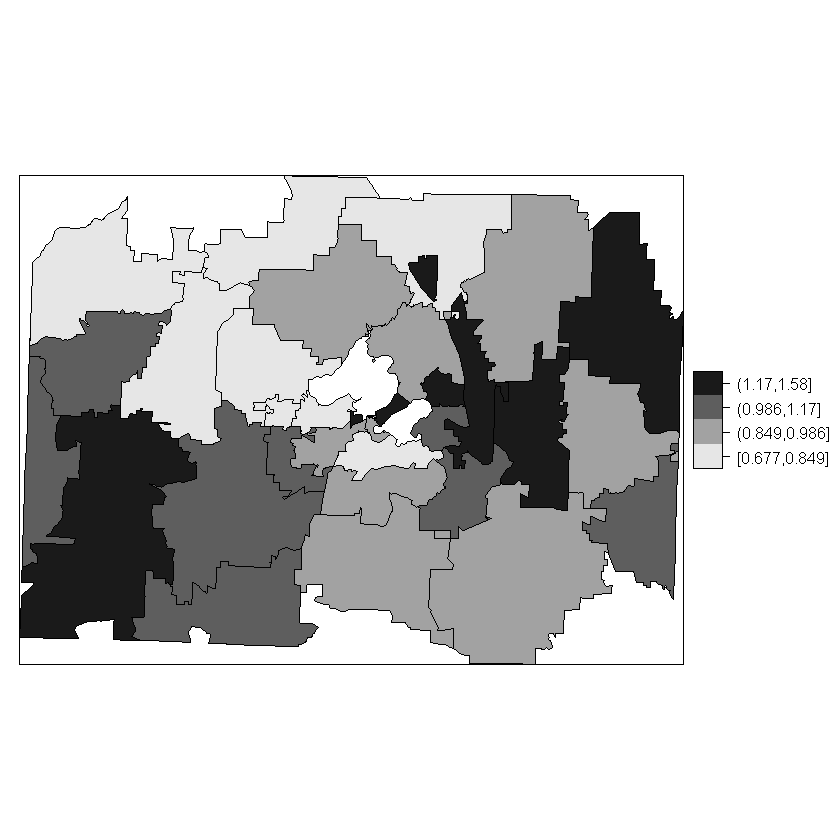

In [39]:
csi = mod1$marginals.random$ID[1:Nareas]
zeta = lapply(csi,function(x) inla.emarginal(exp,x))
zeta.cutoff = quantile(as.numeric(zeta))
cat.zeta = cut(unlist(zeta),breaks=zeta.cutoff,include.lowest=T)
maps.cat.zeta = data.frame(SP_ID=data1$ID,cat.zeta=cat.zeta)
data.zips = attr(zips,"data")
attr(zips,"data") = merge(data.zips,maps.cat.zeta,by.x="ID",by.y="SP_ID")
spplot(obj=zips, zcol="cat.zeta",col.regions=gray(seq(0.9,0.1,length=4)),asp=1)

map posterior mean uncertainty

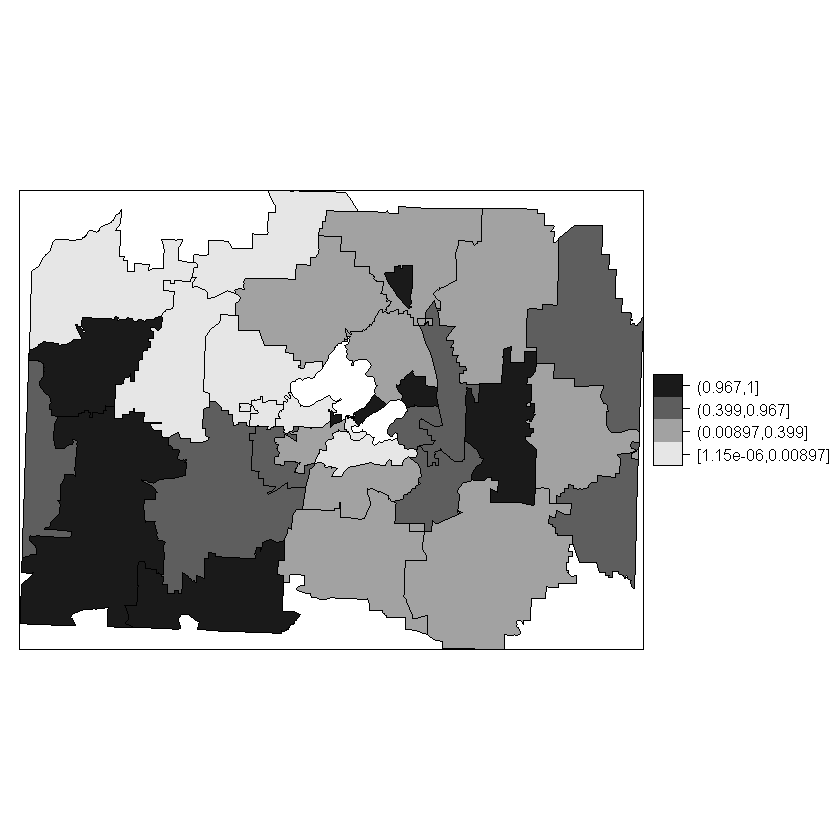

In [49]:
a = 0
prob.csi = lapply(csi, function(x) {1-inla.pmarginal(a,x)})
prob.csi.cutoff = quantile(as.numeric(prob.csi))
cat.prob.csi = cut(unlist(prob.csi),breaks=prob.csi.cutoff,include.lowest=T)
maps.cat.prob.csi = data.frame(SP_ID=data1$ID,cat.prob.csi=cat.prob.csi)
data.zips = attr(zips,"data")
attr(zips,"data") = merge(data.zips,maps.cat.prob.csi,by.x="ID",by.y="SP_ID")
spplot(obj=zips, zcol="cat.prob.csi.y",col.regions=gray(seq(0.9,0.1,length=4)),asp=1)

determine the proportion of variance explained by structured spatial component

In [53]:
mat.marg = matrix(NA,nrow=Nareas, ncol=100000)
m = mod1$marginals.random$ID
for (i in 1:Nareas){
	u = m[[Nareas+i]]
	mat.marg[i,] = inla.rmarginal(100000,u)
}
var.u = apply(mat.marg,2,var)
var.v = inla.rmarginal(100000, inla.tmarginal(function(x) 1/x,
	mod1$marginals.hyper$"Precision for SP_ID (iid component)"))
perc.var.u = mean(var.u/(var.u+var.v)); perc.var.u

marg.hyper = inla.hyperpar.sample(100000,mod1)
perc.var.u1 = mean(marg.hyper[,1]/(marg.hyper[,1]+marg.hyper[,2])); perc.var.u1

Warning message in max(marginal$y):
"no non-missing arguments to max; returning -Inf"Warning message in min(x, na.rm = na.rm):
"no non-missing arguments to min; returning Inf"Warning message in max(x, na.rm = na.rm):
"no non-missing arguments to max; returning -Inf"Warning message in min(m$x):
"no non-missing arguments to min; returning Inf"Warning message in max(m$x):
"no non-missing arguments to max; returning -Inf"

ERROR: Error in seq.default(xmin, xmax, len = n): 'from' cannot be NA, NaN or infinite


# spatio-temporal model

data prep

In [54]:
df.hosp = read.csv("F:/Users/Jason/Desktop/Health_data/INLA_models/Data/admits_daily_ZCTA.csv",header=T)
df.temps = read.csv("F:/Users/Jason/Desktop/Health_data/INLA_models/Data/zip_temperatures_daily.csv",header=T)
df.daily = merge(df.hosp,df.temps,by=c("DATE","ZIP"),all.x=T)

zips = readShapePoly("F:/Users/Jason/Desktop/Health_data/INLA_models/Data/Shapefiles/dane_zip_data.shp")
temp = poly2nb(zips)
nb2INLA("LDN.graph",temp)
adj1 = paste(getwd(),"/LDN.graph",sep="")
H = inla.read.graph(filename="LDN.graph")

data1 = zips@data; data1$ID = as.numeric(data1$ID); data1$MEDIAN_INC = as.numeric(as.character(data1$MEDIAN_INC))
data1$TMIN = NULL; data1$TMAX = NULL; data1$RATE = NULL; data1$JUL_MAX = NULL; data1$JUL_MIN = NULL; data1$GOEGRAPHY = NULL; data1$ID2 = NULL
data.final = merge(df.daily,data1,by="ZIP",all.x=T)
Nareas <- length(data1[,1])

dates = data.frame(levels(factor(data.final$DATE))); colnames(dates)="DATE"
dates$DATE = as.Date(dates$DATE,"%m-%d-%y")
dates$DATE = dates[order(dates$DATE),]
dates$DAY = seq(1,nrow(dates),1)
data.final$DATE = as.Date(data.final$DATE,"%m-%d-%y")
data.final = merge(data.final,dates,by="DATE",all.x=T)
data.final$ID1 = data.final$ID

model fitting

In [58]:
##linear temporal trend
formula1 = ADMITS ~ TMIN + PDISABLED + PNONWHITE + f(ID, model="bym", graph=H, constr=TRUE) + 
              f(ID1, DAY, model="iid", constr=TRUE) + 
              DAY

mdl1 = inla(formula1,family="poisson",data=data.final,E=EXPECTED,
            control.predictor=list(compute=TRUE),
            control.compute=list(dic=TRUE,cpo=TRUE))

##fixed effects
round(mdl1$summary.fixed[,1:5],3)

,mean,sd,0.025quant,0.5quant,0.975quant
(Intercept),0.006,0.071,-0.136,0.007,0.143
TMIN,0.000,0.000,-0.001,0.000,0.001
PDISABLED,-5.917,0.816,-7.492,-5.926,-4.290
DAY,0.000,0.000,0.000,0.000,0.000


Warning message in data.frame(..., check.names = FALSE):
"row names were found from a short variable and have been discarded"

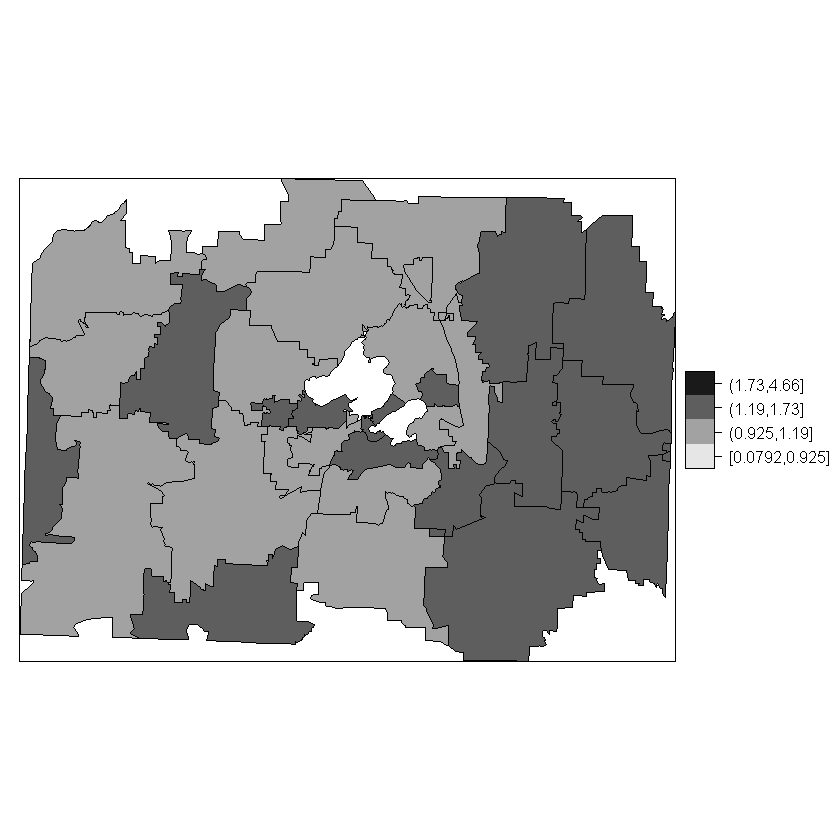

In [71]:
##posterior mean of spatial effect
m = mdl1$marginals.random[[1]][1:64]
prob.csi = unlist(lapply(m,function(x) inla.emarginal(exp,x)))
    
##map relative risks 
prob.csi.cutoff = quantile(as.numeric(prob.csi))
cat.prob.csi = cut(unlist(prob.csi),breaks=prob.csi.cutoff,include.lowest=T)
maps.cat.prob.csi = data.frame(SP_ID=data1$ID,cat.prob.csi=cat.prob.csi)
data.zips = attr(zips,"data")
attr(zips,"data") = merge(data.zips, maps.cat.prob.csi, by.x = "ID", by.y="SP_ID")
spplot(obj=zips, zcol="cat.prob.csi.x",col.regions=gray(seq(0.9,0.1,length=4)),asp=1)